# Multi-step prediction of river flow

In [1]:
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.python.tools import inspect_checkpoint as chkp # import the inspect_checkpoint library
# import tensorboard as tb
import numpy as np
import scipy.io as sio # for working with .mat files
# import pandas as pd # for working with .xlsx files
from openpyxl import load_workbook # for working with .xlsx files
import matplotlib.pyplot as plt # for plotting the data
from datetime import datetime # for keeping separate TB logs for each run
import os, sys

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# define unique name for log directory
now = datetime.now()
logdir = "./logs/multi-step/" + now.strftime("%Y%m%d-%H%M%S") + "/"

print(now.strftime("%Y%m%d-%H%M%S"))

# define constants
input_size = 1
batch_size = 100
n_lstm_layers = 2 # number of vertically stacked LSTM layers
num_units = 64 # hidden state vector size in LSTM cell
num_classes = 1 # output size (only one specific value)
target_shift = 1 # the target is the same time-series shifted by 1 time-step forward
delay = 100 # the number of time-steps from which we are going to predict the next step
pred_step = 1 # the number of time-steps we predict into the future (1 == One-step prediction ; >1 == Multi-step prediction)
net_unroll_size = delay + pred_step - 1 # number of unrolled LSTM time-step cells
n_epochs = 100 # number of epochs
stop_epochs = 20 # if the loss value doesn't improve over the last stop_epochs, the training process will stop

# FIGHTING OVERFITTING:
# enable/disable input and output dropout in LSTM layer
dropout = False
# enable/disable L2 regularization
regularization = False # NOT IMPLEMENTED YET (go to: https://stackoverflow.com/questions/37869744/tensorflow-lstm-regularization)

# continue training the model with saved variables from previeous training
continueLearning = False

# decaying learning rate constants (for exponential decay)
initial_learning_rate = 0.001 # initial learning rate for Adam training algorithm
# Adam already has learning rate decay
decay_steps = n_epochs//10 # every "n_epochs//10" epochs the learning rate is reduced
decay_rate = 1 # the base of the exponential (rate of the decay)

20180507-194624


### 1) DATA from prof. A. Procházka:
* **url:**: http://uprt.vscht.cz/prochazka/pedag/Data/dataNN.zip
* **name**: Weekly Labe river flow
* **Provider source:** Prof. Ing. Aleš Procházka, CSc
* **Span:** 313 weeks ~ 6 years of data
* **Data size:** 313 values

### 2) DATA from Time Series Data Library:
* **url:** https://datamarket.com/data/set/235a/mean-daily-saugeen-river-flows-jan-01-1915-to-dec-31-1979#!ds=235a&display=line
* **name:** Mean daily Saugeen River (Canada) flows
* **Provider source:** Hipel and McLeod (1994)
* **Span:** Jan 01, 1915 to Dec 31, 1979
* **Data size:** 23741 values

In [3]:
# load excel spreadsheet with openpyxl:
filename = './datasets/sugeen-river-flows.xlsx'
xl = load_workbook(filename)

# print sheet names:
print(xl.get_sheet_names())

# get sheet:
sheet = xl.get_sheet_by_name('Mean daily saugeen River flows,')

data = []

# fill a list with values from cells:
for cell in sheet['B16:B23756']:
    data.append(cell[0].value)
    
# convert list to numpy array and reshape to a column vector
data = np.array(data)
data = np.reshape(data,(1,-1))

print(np.shape(data))

# normalize the data to interval (0,1) <- DONT!
min_data = np.min(data)
max_data = np.max(data)
# data = np.divide(np.subtract(data,min_data),np.subtract(max_data,min_data)).flatten()
# !!! CENTERING data:
# normalize the data to interval (-1,1) (cca 0 mean and 1 variance)
# data = data[0,:120]
mean_data = np.mean(data) # mean
std_data = np.std(data) # standard deviation
data = np.divide(np.subtract(data,mean_data),std_data).flatten()

# divide the data into training, testing and validation part
days_in_data = np.shape(data)[0]
days_in_year = 365.25
years_in_data = days_in_data/days_in_year

years_in_train = int(years_in_data*0.7) # 70% of data rounded to the number of years
years_in_test = int(np.ceil(years_in_data*0.15)) # 15% of data rounded to the number of years

days_train = int(years_in_train*days_in_year) # number of days in training data
days_test = int(years_in_test*days_in_year) # number of days in testing data

end_of_train = days_train
end_of_test = days_train + days_test

x_train = data[:end_of_train]
x_test = data[end_of_train:end_of_test]
x_validation = data[end_of_test:]

print(np.shape(x_test))

['Mean daily saugeen River flows,']
(1, 23741)
(3652,)


In [4]:
# define the shifted time-series (targets)
y_train = np.roll(x_train, target_shift)
y_test = np.roll(x_test, target_shift)
y_validation = np.roll(x_validation, target_shift)

# delete the first elements of the time series that were reintroduced from the end of the timeseries
y_train[:target_shift] = 0
y_test[:target_shift] = 0
y_validation[:target_shift] = 0

In [5]:
# reset TensorFlow graph
tf.reset_default_graph()

# define tensorflow constants
min_of_data = tf.constant(min_data, dtype=tf.float32, name='min_of_data')
max_of_data = tf.constant(max_data, dtype=tf.float32, name='max_of_data')
mean_of_data = tf.constant(mean_data, dtype=tf.float32, name='mean_of_data')
std_of_data = tf.constant(std_data, dtype=tf.float32, name='std_of_data')

# define output weights and biases
with tf.name_scope("output_layer"):
    weights_out = tf.Variable(tf.random_normal([num_units,num_classes]),name='weights_out')
    bias_out = tf.Variable(tf.random_normal([num_classes]),name='biases_out')

# define placeholders for the batches of time-series
x = tf.placeholder(tf.float32,[None, net_unroll_size, input_size],name='x') # batch of inputs
y = tf.placeholder(tf.float32,[None, num_classes, pred_step],name='y') # batch of labels

In [6]:
# processing the input tensor from [batch_size,delay,input_size] to "delay" number of [batch_size,input_size] tensors
input=tf.unstack(x, net_unroll_size, 1, name='LSTM_input_list') # create list of values by unstacking one dimension

In [7]:
# function to create an LSTM cell:
def make_cell(num_units):
    return rnn.LSTMCell(num_units, state_is_tuple=True, activation=tf.tanh)

# define an LSTM network with 'n_lstm_layers' layers
with tf.name_scope("LSTM_layer"):
    lstm_cells = rnn.MultiRNNCell([make_cell(num_units) for _ in range(n_lstm_layers)], state_is_tuple=True)
    
    # add dropout to the inputs and outputs of the LSTM cell (reduces overfitting)
    if dropout == True:
        lstm_cells = rnn.DropoutWrapper(lstm_cells, input_keep_prob=0.5, output_keep_prob=0.5, state_keep_prob=1.0)
    
    # create static RNN from lstm_cell
    outputs,_ = rnn.static_rnn(lstm_cells, input, dtype=tf.float32)

In [8]:
# generate a list of predictions based on the last "pred_step" time-step outputs (multi-step prediction)
prediction = [tf.matmul(outputs[-i-1],weights_out) + bias_out for i in (range(pred_step))] # newest prediction first
prediction = prediction[::-1] #reverse the list (oldest prediction first)

prediction = tf.reshape(prediction,[batch_size,num_classes,pred_step])

In [9]:
# define loss function with regularization
# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=y))
with tf.name_scope("loss"):
#    regularization_cost = tf.reduce_sum([ tf.nn.l2_loss(v) for v in tv ])
    loss = tf.sqrt(tf.losses.mean_squared_error(predictions=prediction,labels=y)) # RMSE (root mean squared error)

# exponential decay of learning rate with epochs
global_step = tf.Variable(1, trainable=False, name='global_step') # variable that keeps track of the step at which we are in the training
increment_global_step_op = tf.assign(global_step, global_step+1,name='increment_global_step') # operation that increments global step by one
# decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                           decay_steps, decay_rate, staircase=True) # decay at discrete intervals

# define Adam optimizer for training of the network
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [10]:
# denormalize data (from (0,1)):
# denormalized_prediction = min_of_data + tf.multiply(prediction, tf.subtract(max_of_data,min_of_data))
# denormalized_y = min_of_data + tf.multiply(y, tf.subtract(max_of_data,min_of_data))

# denormalize data (from (-1,1)): <- better
denormalized_prediction = mean_of_data + tf.multiply(prediction, std_of_data)
denormalized_y = mean_of_data + tf.multiply(y, std_of_data)

# calculate relative error of denormalized data:
with tf.name_scope("relative_error"):
    relative_error = tf.reduce_mean(tf.divide(tf.abs(tf.subtract(denormalized_prediction,denormalized_y)),denormalized_y))

In [11]:
# TensorBoard summaries (visualization logs)
# histogram summary for output weights
w_out_summ = tf.summary.histogram("w_out_summary", weights_out)
# scalar summary for loss function
# training_loss_summ = tf.summary.scalar("training_loss",loss)
# testing_loss_summ = tf.summary.scalar("testing_loss",loss)
# scalar summary for relative error
# training_error_summ = tf.summary.scalar("relative_training_error",relative_error)
# testing_error_summ = tf.summary.scalar("relative_testing_error",relative_error)

# NOT USEFUL HERE
# merge the summaries of all tf.summary calls (for TensorBoard visualization)
# merged = tf.summary.merge_all()

In [12]:
# function for generating the time-series batches
def create_batch(x_data,y_data,batch_size,index):
    
    x_batch = np.zeros([batch_size,delay,input_size])
    x_pad = np.zeros([batch_size,pred_step-1,input_size])
    y_batch = np.zeros([batch_size,num_classes,pred_step])
    
    step = index*(batch_size*pred_step)
    
    for i in range(batch_size):
        x_batch[i,:,:] = np.reshape(x_data[step+i*pred_step:step+i*pred_step+delay],(delay,num_classes))
        y_batch[i,:] = np.reshape(y_data[step+delay+i*pred_step+1:step+delay+i*pred_step+1+pred_step],(1,num_classes,-1))

    # the last "pred_step - 1" columns in x_batch are padded with 0
    # because there are no inputs into the net at these time steps
    x_batch = np.hstack((x_batch, x_pad))
    
#    print(x_batch)
#    print('________________')
#    print(y_batch)
#    print('================')
    
    return x_batch, y_batch


In [13]:
def run_model(inputs,labels,n_iter,save,train=False):
    # Here are the important things that need to happen while running the model
    
    prediction_list = [] # list for prediction results
    loss_val_sum = 0 # sum of the loss function throughout the whole data
    error_val_mean = 0
    prefix = ""
    
    for i in range(n_iter):
        # training batch
        x_batch, y_batch = create_batch(inputs,labels,batch_size,i)

        feed_dict = {x: x_batch, y: y_batch}
        
        # train the net on the data
        if train:
            session.run(optimizer,feed_dict=feed_dict) # run the optimization on the current batch
            prefix = "Training_" # for summary writer
        else:
            prefix = "Testing_" # for summary writer

        loss_val, prediction_val, error_val = session.run((loss, denormalized_prediction, relative_error), feed_dict=feed_dict)
        
        # prediction_val is a list of length "pred_step" with arrays of "batch_size" output values
        # convert to numpy array of shape (batch_size, pred_step)
        prediction_val = np.array(prediction_val)
        # reshape the array to a vector of shape (1, pred_step*batch_size)
        prediction_val = np.reshape(prediction_val, (1, pred_step*batch_size))
        
        loss_val_sum += loss_val # sum the losses across the batches
        
        # mean of prediction error values:
        if i == 0:
            error_val_mean = error_val
        else:
            error_val_mean = (error_val_mean + error_val)/2
            
        # save the results
        if save:
            # save the batch predictions to a list
            prediction_list.extend(prediction_val[0,:])
            
    # the mean value of loss (throughout all the batches) in current epoch 
    loss_val_mean = loss_val_sum/n_iter
        
    # Create a new Summary object for sum of losses and mean of errors
    loss_summary = tf.Summary()
    error_summary = tf.Summary()
    loss_summary.value.add(tag="{}Loss".format(prefix), simple_value=loss_val_mean)
    error_summary.value.add(tag="{}Error".format(prefix), simple_value=error_val_mean)

    # Add it to the Tensorboard summary writer
    # Make sure to specify a step parameter to get nice graphs over time
    summary_writer.add_summary(loss_summary, epoch)
    summary_writer.add_summary(error_summary, epoch)

    return loss_val_mean, error_val_mean, prediction_list

In [14]:
# Function for saving the best net coefficients and stopping early if the loss val is not improving
def early_stopping(loss_val,epoch,stop_epochs):
    """
    Save the model coefficients if the data loss function value is better than the last
    loss function value.
    Return the epoch at which the best loss was and the value of the loss (ergo at which the last checkpoint was created)
    """
    
    stop_training = False
    
    # initialize function attributes
    if not hasattr(early_stopping,"best_loss"):
        early_stopping.best_loss = loss_val
        early_stopping.best_epoch = epoch
    
    # if loss val is better than best_loss save the model parameters
    if loss_val < early_stopping.best_loss:
        saver.save(session, './checkpoints/Multi-Step_LSTMforPredictingLabeFlow') 
        early_stopping.best_loss = loss_val
        early_stopping.best_epoch = epoch
        print("Model saved.")  
    
    # if the loss didn't improve for the last stop_epochs number of epochs then the training process will stop
    if (epoch - early_stopping.best_epoch) >= stop_epochs:
        stop_training = True              
    
    return early_stopping.best_loss, early_stopping.best_epoch, stop_training

In [15]:
# TRAINING THE NETWORK

# number of iterations in each epoch
# n_iter = int(np.rint((len(x_train)-delay-pred_step)//(batch_size*pred_step+delay))) # round to nearest integer
n_iter = (len(x_train)-delay)//(batch_size*pred_step)
n_iter_test = (len(x_test)-delay)//(batch_size*pred_step)
n_iter_validation = (len(x_validation)-delay)//(batch_size*pred_step)

# initializer of TF variables
init = tf.global_variables_initializer()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

with tf.Session() as session:
    
    # initialize helping variables
    stop_training = False
    best_epoch = n_epochs
    
    # Restore variables from disk if continueLearning is True.
    if continueLearning:
        # restoring variables will also initialize them
        saver.restore(session, './checkpoints/Multi-Step_LSTMforPredictingLabeFlow')
        print("Model restored.")
    else:
        session.run(init) # initialize variables

    
    # Create a SummaryWriter to output summaries and the Graph
    # in console run 'tensorboard --logdir=./logs/'
    summary_writer = tf.summary.FileWriter(logdir=logdir, graph=session.graph)
    
    for epoch in range(n_epochs):
        # TRAINING
        loss_val, error_val, _ = run_model(x_train,y_train,n_iter,save=False,train=True)
        
        # TESTING
        loss_val_test, error_val_test, _ = run_model(x_test,y_test,n_iter_test,save=False,train=False)
        
        # write the summaries of testing data at epoch in TensorBoard
#        summary_writer.add_summary(summary_test, epoch)
            
        # increment global step for decaying learning rate at each epoch
        session.run(increment_global_step_op)

        # Printing the results at every "n_epochs//10" epochs
        if epoch % (n_epochs//10) == 0:
            print("Epoch: {}".format(epoch))
            print("TRAINING Loss: {}".format(loss_val))
            print("TRAINING Error: {}".format(error_val))
            print("TESTING Loss: {}".format(loss_val_test))
            print("TESTING Error: {}".format(error_val_test))
            # save the trained net and variables for later use if the test loss_val is better than the last saved one
            best_loss, best_epoch, stop_training = early_stopping(loss_val_test,epoch,stop_epochs)
            # flush the summary data into TensorBoard
            # summary_writer.flush()
            print("____________________________")
            
        # Stop the training process
        if stop_training:
            print("The training process stopped prematurely at epoch {}.".format(epoch))
            break

Epoch: 0
TRAINING Loss: 0.41462138475724525
TRAINING Error: 0.31029350585004667
TESTING Loss: 0.3467943962131228
TESTING Error: 0.36952154525780856
____________________________
Epoch: 10
TRAINING Loss: 0.21929663599131663
TRAINING Error: 0.14618051775090923
TESTING Loss: 0.1963257037103176
TESTING Error: 0.1426528908942623
Model saved.
____________________________
Epoch: 20
TRAINING Loss: 0.2180489874930561
TRAINING Error: 0.14289542691361273
TESTING Loss: 0.1973141741539751
TESTING Error: 0.1474562159488197
____________________________
Epoch: 30
TRAINING Loss: 0.2179284339107893
TRAINING Error: 0.14498046976222284
TESTING Loss: 0.19636670819350652
TESTING Error: 0.14606580641962005
____________________________
The training process stopped prematurely at epoch 30.


In [16]:
# Restoring the model coefficients with best results
with tf.Session() as session:
        
    # restore the net coefficients with the lowest loss value
    saver.restore(session, './checkpoints/Multi-Step_LSTMforPredictingLabeFlow')
    print('Restored model coefficients at epoch {} with TESTING loss val: {:.4f}'.format(best_epoch, best_loss))
        
    # run the trained net with best coefficients on all time-series and save the results
    loss_val, error_val, prediction_list = run_model(x_train,y_train,n_iter,save=True,train=False)
    loss_val_test, error_val_test, prediction_list_test = run_model(x_test,y_test,n_iter_test,save=True,train=False)
    loss_val_validation, error_val_validation, prediction_list_validation = run_model(x_validation,y_validation,n_iter_validation,save=True,train=False)
    
    print("Best epoch: {}".format(best_epoch))
    print("TRAINING Loss: {}".format(loss_val))
    print("TRAINING Error: {}".format(error_val))
    print("TESTING Loss: {}".format(loss_val_test))
    print("TESTING Error: {}".format(error_val_test))       
    print("VALIDATION Loss: {}".format(loss_val_validation))
    print("VALIDATION Error: {}".format(error_val_validation))

INFO:tensorflow:Restoring parameters from ./checkpoints/Multi-Step_LSTMforPredictingLabeFlow
Restored model coefficients at epoch 10 with TESTING loss val: 0.1963
Best epoch: 10
TRAINING Loss: 0.22020028220729593
TRAINING Error: 0.16597780949566202
TESTING Loss: 0.1963257037103176
TESTING Error: 0.1426528908942623
VALIDATION Loss: 0.2220860028905528
VALIDATION Error: 0.13037005184726622


In [17]:
# Shift the predictions "delay" time-steps to the right
prediction_train = np.array(prediction_list)
prediction_test = np.array(prediction_list_test)
prediction_validation = np.array(prediction_list_validation)

print(np.shape(prediction_train))

prediction_train = np.pad(prediction_train,pad_width=((delay,0))
                          ,mode='constant',constant_values=0) # pad with "delay" zeros at the start of first dimension
prediction_test = np.pad(prediction_test,pad_width=((delay,0))
                         ,mode='constant',constant_values=0) # pad with "delay" zeros at the start of first dimension
prediction_validation = np.pad(prediction_validation,pad_width=((delay,0))
                         ,mode='constant',constant_values=0) # pad with "delay" zeros at the start of first dimension

print(np.shape(prediction_train))

(16300,)
(16400,)


In [18]:
# Denormalize target values
def denormalize(labels):
    # denormalize the labels
    # denormalized_labels = min_data + labels*(max_data - min_data)
    # denormalize the labels from (-1,1)
    denormalized_labels = mean_data + labels*std_data
    
    return denormalized_labels


y_train_denorm = denormalize(y_train)
y_test_denorm = denormalize(y_test)
y_validation_denorm = denormalize(y_validation)


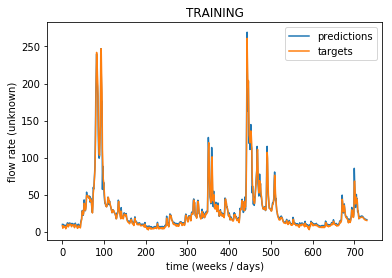

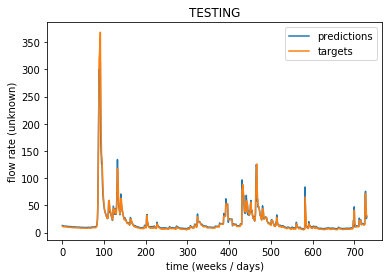

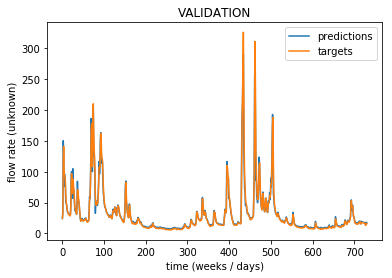

In [19]:
# Plot the results
def plot_results(predictions, targets):
    plt.plot(predictions)
    plt.plot(targets)
    plt.xlabel('time (weeks / days)')
    plt.ylabel('flow rate (unknown)')
    plt.legend(['predictions', 'targets'])
    plt.draw()

plot_start = int(days_in_year*3)
plot_end = int(days_in_year*5)
    
f_training = plt.figure()
plot_results(prediction_train[plot_start:plot_end], y_train_denorm[plot_start:plot_end])
plt.title('TRAINING')

f_testing = plt.figure()
plot_results(prediction_test[plot_start:plot_end], y_test_denorm[plot_start:plot_end])
plt.title('TESTING')

f_validation = plt.figure()
plot_results(prediction_validation[plot_start:plot_end], y_validation_denorm[plot_start:plot_end])
plt.title('VALIDATION')
plt.show()

In [20]:
# Save the figures:
img_save_dir = "IMG\\" + now.strftime("%Y%m%d-%H%M%S")
save_dir_path = os.path.join(os.curdir, img_save_dir)
os.makedirs(save_dir_path, exist_ok=True)

f_training.savefig(save_dir_path + "\\training.pdf", bbox_inches='tight')
f_testing.savefig(save_dir_path + "\\testing.pdf", bbox_inches='tight')
f_validation.savefig(save_dir_path + "\\validation.pdf", bbox_inches='tight')

print("Figures saved to: {}".format(save_dir_path))

Figures saved to: .\IMG\20180507-194624


## Following cells are for debugging purposes

In [21]:
## TODO:
# - Variable length last batch to make use of all the available data!!!
# - plot every n_epochs//10 into tensorboard (different charts?)
# - try chaning num_units --- DONE
# - try chaning delay
# - try chaning n_lstm_layers
# - regularization (not necessarry)

# - test and validation --- DONE
# - drift??? --- DONE
# - Show the graph in TensorBoard -- DONE
# - add Dropout layer -- DONE
# - divide loss sum by n_iter to make it a loss val mean !!! --- DONE
# - add relative error between the predictions and targets --- DONE

decayed_learning_rate_test = 0.01 * 0.90 ** (2000 / 1000)
print(decayed_learning_rate_test)

0.008100000000000001


In [22]:
np.mean(x_train)
print(np.shape(x_test), np.shape(x_test[:4000]))

(3652,) (3652,)


In [23]:
print(prediction_train)

[ 0.        0.        0.       ... 35.40853  46.245827 65.47731 ]


In [24]:
best_loss

0.1963257037103176

In [25]:
best_epoch

10

In [26]:
prediction_validation

array([ 0.      ,  0.      ,  0.      , ..., 29.192705, 25.589241,
       26.021202], dtype=float32)